<a href="https://colab.research.google.com/github/Ste1nb0cK/Proyecto--Simulaci-n-Gas/blob/main/CodAnimaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import *
import glob
import random 
import moviepy.editor as mpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%load_ext Cython
import matplotlib.pyplot as plt
from numpy import linalg

In [5]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)*1.1<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        if choque_pared_derecha and choque_pared_izquierda and choque_pared_superior and choque_pared_inferior :
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):
      """Método que actualiza las velocidades de dos partículas después de chocar
       Definimos las magnitudes a usar para resolver el choque"""
      M1=self.masa
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      cdef bint choque=self.ver_colision_pp
      if choque:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)#Se resuleven los choques tal cual el modelo bidimensional que se tiene
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  

    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        #Ahora miramos cual fue la pared con que se chocó e invertimos la coordenada teniendo en cuenta eso
        if not choque_pared_derecha or not choque_pared_izquierda:
            self.velocidad[0] = -1* self.velocidad[0]
        elif not choque_pared_superior or not choque_pared_inferior:
            self.velocidad[1] = -1* self.velocidad[1]
       
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector
    

In [6]:
print(np.random.rand(5))
A=np.random.randint(-100,100,(500,2))
b=list(A)
print(b)

[0.30593651 0.66786346 0.94621045 0.61775215 0.80275438]
[array([ 71, -50]), array([-37, -60]), array([-60,  92]), array([-25, -44]), array([-61,  89]), array([ 87, -57]), array([60, 54]), array([-98,  20]), array([ 83, -47]), array([ 6, 55]), array([-39,  14]), array([40,  8]), array([ -8, -92]), array([-44,  38]), array([68, 68]), array([-78,  94]), array([ -1, -37]), array([27, 71]), array([-67, -92]), array([-4, 89]), array([-27, -95]), array([27, 95]), array([36, 18]), array([-49,  65]), array([38, 45]), array([ -3, -24]), array([-64,  74]), array([-15, -38]), array([-54,  15]), array([-36,  23]), array([-71,  46]), array([-34,   5]), array([-28,  70]), array([-36, -35]), array([-11, -94]), array([47, 44]), array([-64,  80]), array([-63,  13]), array([ 99, -69]), array([66, 65]), array([53, -2]), array([-37,  96]), array([ 5, 28]), array([12, 38]), array([ 64, -77]), array([10, 37]), array([-97, -53]), array([39, 99]), array([ 12, -65]), array([-28,  95]), array([ 71, -34]), array

In [7]:

#Prototipo de la función final, recibe las dimensiones de la caja, el rango de velocidades inciales y el número de partículas
#Si algo podemos establecer por defecto que las masas y los radios sean los mismos por defecto o cómo quieran
def funcion_simuladora(lx,ly,v1,v2,n):
#Por el momento se crea un arreglo vacío de enteros para las posiciones iniciales
  posiciones=np.zeros((n,2))
  
  for i in range(n):
    #Se llena el arreglo con números aleatorios dentro del rango de las dimensiones de la caja
    posiciones[i][0]=np.random.uniform(0,lx)
    posiciones[i][1]=np.random.uniform(0,ly)
  #Se convierte el arreglo en una lista
  posiciones_lista=list(posiciones)
  #Las velocidades se crean normalmente con velocidades aleatorias dentro del rango establecido, el intervalo (v1,v2)
  velocidades_lista=list(np.random.uniform(v1,v2,(n,2)))
  #Ahora creamos una lista vacía donde irán objetos de la clase partícula
  lista_de_particulas=[]
  #Llenamos la lista con partículas que tendrán posiciones provenientes de posiciones_lista y velocidades_lista, le puse una masa y un radio aleatorio 
  #entre 0 y 5.
  for j in range(n):
    Pn=Particula(tuple(posiciones_lista[j]),tuple(velocidades_lista[j]),np.random.randint(0,5),np.random.randint(0,5))
    lista_de_particulas.append(Pn)
  
  
  #Ahora queremeos hacer que si las partículas se cren superpuestas de alguna manera, eliminamos una y creamos otra nueva
  #luego añadimos la nueva partícula a la lista de partículas
  #pero lo haré
  for i in range(n):
   for p1 in lista_de_particulas:
    for p2 in lista_de_particulas:
     if p1.ver_colision_pp(p2):
       p_nueva=Particula(tuple([(random.uniform(0,lx),random.uniform(0,ly)) for x in range(1)][0]),
       tuple([(random.uniform(v1,v2),random.uniform(v1,v2)) for x in range(1)][0]), np.random.randint(0,5),np.random.randint(0,5))
                                                      
       lista_de_particulas.pop(i)
       lista_de_particulas.append(p_nueva)
  #Nos retorna la lista con las partículas creadas, acá le puse que me devolviera solo la primera para demostrar funcionalidad

  return lista_de_particulas[0]


In [10]:
#Prueba
A=funcion_simuladora(100,100,0,100,5)
for j in range(10):
  A.paso_dt(1)
print(A.posicion_n)


[array([ 4.82594252, 34.27598953]), array([22.31955099, 34.94184715]), array([39.81315947, 35.60770476]), array([57.30676794, 36.27356237]), array([74.80037642, 36.93941998]), array([92.29398489, 37.6052776 ]), array([109.78759336,  38.27113521]), array([127.28120184,  38.93699282]), array([144.77481031,  39.60285044]), array([162.26841879,  40.26870805]), array([179.76202726,  40.93456566])]


In [11]:
A=np.zeros((10,2),dtype="int")
for n in range(10):
 A[n][0]=np.random.randint(0,10)
 A[n][1]=np.random.randint(0,10)

B=list(A)
tuple(B[0])


(3, 7)

[-1.  1.]
[1. 1.]
[array([0., 0.]), array([1., 1.]), array([2., 2.]), array([1., 3.]), array([0., 4.]), array([-1.,  5.]), array([-2.,  6.]), array([-3.,  7.]), array([-4.,  8.]), array([-5.,  9.]), array([-6., 10.])]


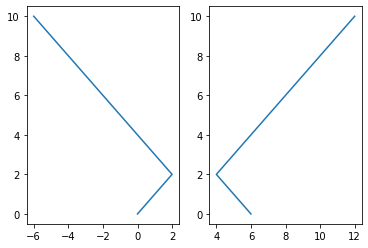

In [12]:
#Prueba resolver colision con dos partículas bidimensional
P1=Particula((0,0),(1,1),2,1)
P2=Particula((6,0),(-1,1),2,1)
for j in range(10):
  P1.paso_dt(1)
  P2.paso_dt(1)
  
  if P1.ver_colision_pp(P2):
    P1.resolver_colision_particula(P2)

x=[]
y=[]
for n in P1.posicion_n:
  x.append(n[0])
  y.append(n[1])
x1=[]
y1=[]
for n1 in P2.posicion_n:
  x1.append(n1[0])
  y1.append(n1[1])

plt.subplot(121)
plt.plot(x,y)
plt.subplot(122)
plt.plot(x1,y1)


print(P1.velocidad)
print(P2.velocidad)   
print(P1.posicion_n)

In [46]:
#las listas l1 y l2 contienen la informacion de los radios en el tiempo de la particula 1 y 2 correspondientemente 
l1=[]
l2=[]

#Como hay posiciones menores que cero entonces lo corregi corriendo las posiciones en x
l1.append(np.array(x)+6)
l1.append(y)
l2.append(np.array(x1)+6)
l2.append(y1)

#la ListaOf contendra a l1 y l2 pero el codigo esta elaborado para n particulas en ListaOf
ListaOf=[]
ListaOf.append(l1)
ListaOf.append(l2)

BoxOf=np.zeros((18,10))

for particle in range(0,len(ListaOf)):
  for i in range(0,len(particle[0])):
    x2,y2=circle(particle[0][x],particle[1][x],1)
    BoxOf[x2,y2]=255
    Gif.append(np.copy(BoxOf))
    BoxOf[x2,y2]=0

#plt.imshow(Gif[20])






In [48]:
print("Datos x")
print(ListaOf[0][0])
print(ListaOf[1][0])
print("Datos y")
print(ListaOf[0][1])
print(ListaOf[1][1])


Datos x
[6. 7. 8. 7. 6. 5. 4. 3. 2. 1. 0.]
[12. 11. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
Datos y
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


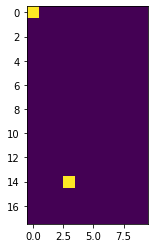

In [34]:
BoxOf=np.zeros((18,10))
xa,ya=circle(-4,3,1)
xb,yb=circle(0,0,1)
BoxOf[xa,ya]=255
BoxOf[xb,yb]=255
plt.imshow(BoxOf)
